# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

### rolling and slicing wg for `ds_tns` and `ds_vel`, and saving to cloud

### Begin nb

In [2]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [14]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7c41e47813214fae911aa1fb53cd27ca Dashboard: /services/dask-gateway/clusters/prod.7c41e47813214fae911aa1fb53cd27ca/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [142]:
from dask_gateway import Gateway
g = Gateway()
g.list_clusters()[0].name

'prod.b25aa347b02246d2a5fb832642991c54'

In [178]:
client.close()
cluster.close()

In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [6]:
xr.set_options(display_style='text')

In [7]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel_wg.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr'))
#ds_tmp_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')) #from sigma-budget-zspace-sose.ipynb

In [8]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, XG: 571, YC: 95, YG: 96, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.1 295.2 295.4 ... 29.75 29.92
  * YC                        (YC) float32 -77.87 -77.71 ... -62.37 -62.21
  * Z                         (Z) float32 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.2 295.3 ... 29.83 30.0
  * YG                        (YG) float32 -77.96 -77.79 ... -62.29 -62.12
  * Zl                        (Zl) float32 0.0 -10.0 ... -5.2e+03 -5.45e+03
Data variables:
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH           (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhods_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhodt_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 96, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [9]:
pref = 2000

In [10]:
mask = ds.surface_flux_conv_SLT.where(ds.surface_flux_conv_SLT!=0)

In [11]:
mask

<xarray.DataArray 'surface_flux_conv_SLT' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<where, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

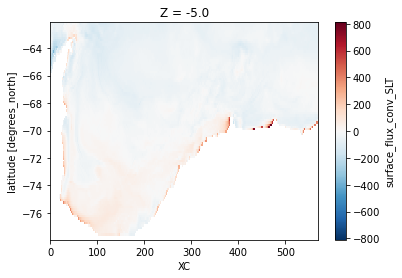

In [12]:
mask.mean(dim='time')[0].drop('XC').plot()

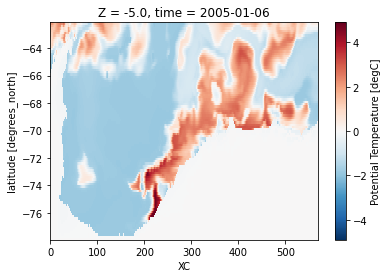

In [13]:
ds_tns.THETA[0,0].where(mask[0,0]).drop('XC').plot()

### Checking if `rhs` and `lhs` seem to match

In [15]:
ds_sig_salt.data_vars

Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [16]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [17]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<add, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

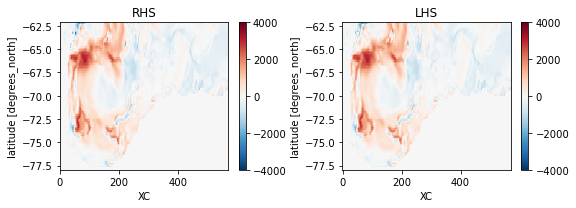

In [18]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].drop('XC').plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].drop('XC').plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [19]:
import dask.array as dsa

In [20]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True)#.load()

In [21]:
sigma2

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<transpose, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

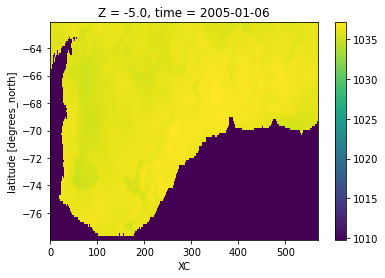

In [22]:
sigma2[0,0].drop('XC').plot()

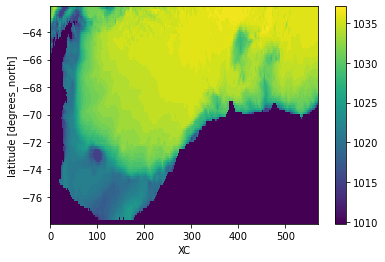

In [23]:
sigma2.mean(dim=['time', 'Z']).drop('XC').plot()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

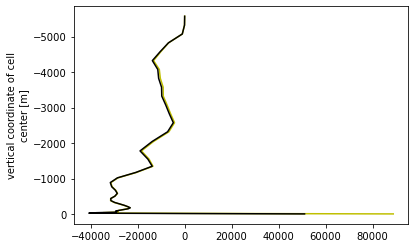

In [24]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['YC', 'XC'])/ total_time).plot(y='Z', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k')

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

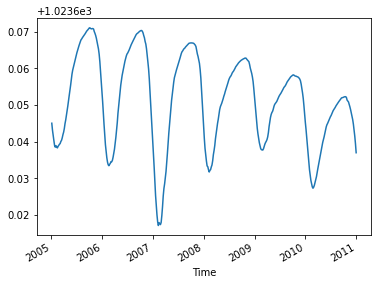

In [25]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['XC', 'YC', 'Z']).plot()

In [28]:
sigma2.min().values

array(1009.78870743)

In [29]:
sigma2.max().values

array(1037.55056821)

In [30]:
sigma2.where(mask).min().values

array(1009.78870743)

In [26]:
# define bins
delta_sigma = 0.01
sigma_bins = np.arange(1035.55, 1037.55, delta_sigma)

In [32]:
sigma_bins.size

2777

In [27]:
ds = ds.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})
coords = coords.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})

In [29]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).load()

In [30]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[1.13423144e+11, 1.31609551e+11, 1.57247256e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.32335867e+11, 1.35934326e+11, 1.52830657e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.55675558e+10, 7.18447876e+10, 1.00385727e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.46686310e+09, 4.68402163e+09, 1.48489843e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.07137587e+09, 1.60360922e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.79996928e+09, 4.59207616e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

(1036.9, 1037.3)

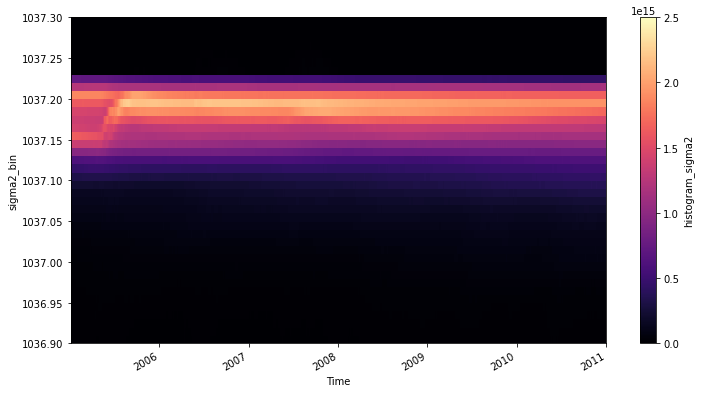

In [31]:
#most volumous water has densities up to 1037.20kg/m^3
#how to check the single-value density for most volumous?
sigma_dist.plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3)

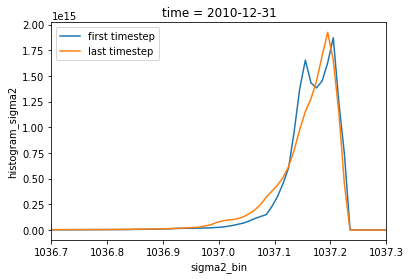

In [32]:
#waters with density up to 1037.13 got denser?
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

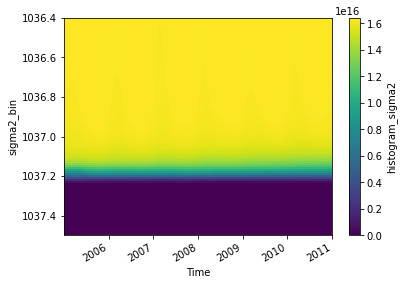

In [33]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.5, 1036.4)

In [34]:
V

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64139676e+16, 1.64140992e+16, 1.64142127e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64159155e+16, 1.64160514e+16, 1.64161838e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64163349e+16, 1.64164068e+16, 1.64164724e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173384e+16, 1.64173431e+16, 1.64173446e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173369e+16, 1.64173385e+16, 1.64173416e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173051e+16, 1.64173097e+16, 1.64173145e+16]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

(1037.5, 1036.5)

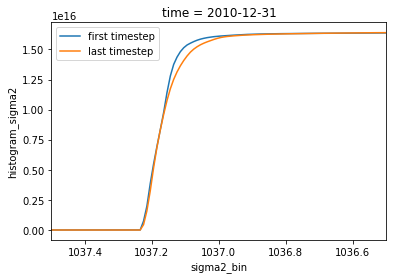

In [35]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [36]:
delta_V = V.diff(dim='time')

In [37]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 437, sigma2_bin: 199)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.94787812e+12,  1.95220289e+12,  1.97111561e+12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.19444862e+11,  3.55355323e+11,  2.88587012e+11],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.05210419e+09,  2.12652559e+10,  3.74589320e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.12162227e+09, -5.92249907e+09, -7.55408371e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.48489843e+09, -4.56531085e+09, -2.96079808e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.18640164e+10, -2.88755494e+10, -2.71469560e+10]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [38]:
dt = ds.time.diff(dim='time').astype(np.float64) / 1e9

In [39]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

## $\frac{\partial \mathcal{V}}{\partial t}$

In [40]:
delta_V.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [41]:
dt.time.dtype

dtype('<M8[ns]')

In [42]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [43]:
dt_time = dt.time.data

In [44]:
dVdt = delta_V / dt

In [45]:
dt

<xarray.DataArray 'time' (time: 437)>
array([432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
...
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000.])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [46]:
dVdt

<xarray.DataArray (time: 437, sigma2_bin: 199)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.50897712e+06,  4.51898817e+06,  4.56276762e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.70937180e+05,  8.22581767e+05,  6.68025491e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16946856e+04,  4.92251293e+04,  8.67104907e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.11148664e+04, -1.37094886e+04, -1.74863049e+04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.43726489e+03, -1.05678492e+04, -6.85369926e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.37592972e+04, -6.68415496e+04, -6.28401760e+04]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

(1035.5, 1037.3)

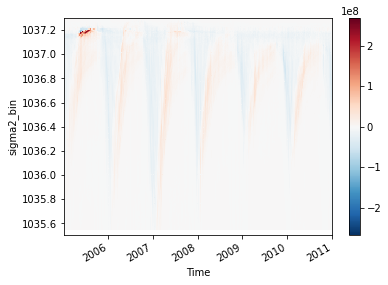

In [47]:
dVdt.plot(x='time')
plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [49]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[-7172956.10454818, -7655417.42540483, -8085171.1515464 , ...,
               0.        ,        0.        ,        0.        ],
       [ 2504602.97945385,  1667390.14222579,  3906577.14988093, ...,
               0.        ,        0.        ,        0.        ],
       [  296299.10556494,   403174.45544963,   581782.68925796, ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [  -39980.49972141,  -107475.9904712 ,   -34312.24048652, ...,
               0.        ,        0.        ,        0.        ],
       [   69205.99491557,    81527.30795351,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [  131151.84057438,  -193441.38385013,        0.        , ...,
               0.        ,        0.        ,        0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

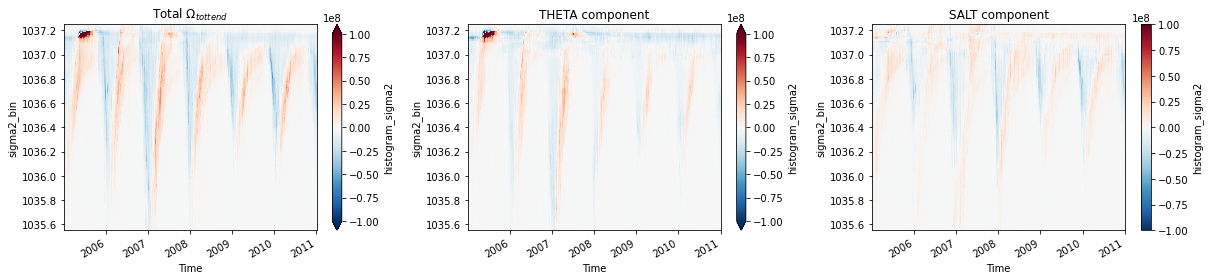

In [54]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

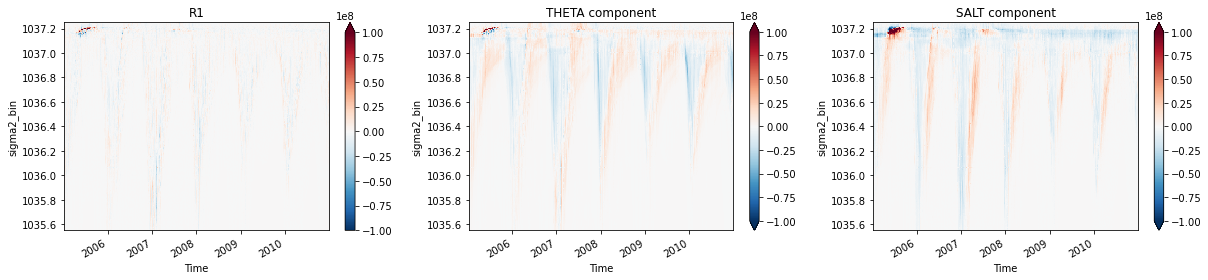

In [56]:
R1 = dVdt - omega_total[1:-1]
R1_th = dVdt - omega_total_th[1:-1]
R1_slt = dVdt - omega_total_slt[1:-1]

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

In [70]:
plot_terms = [dVdt, omega_total, R1, dVdt, omega_total_th, R1_th, dVdt, omega_total_th, R1_slt]

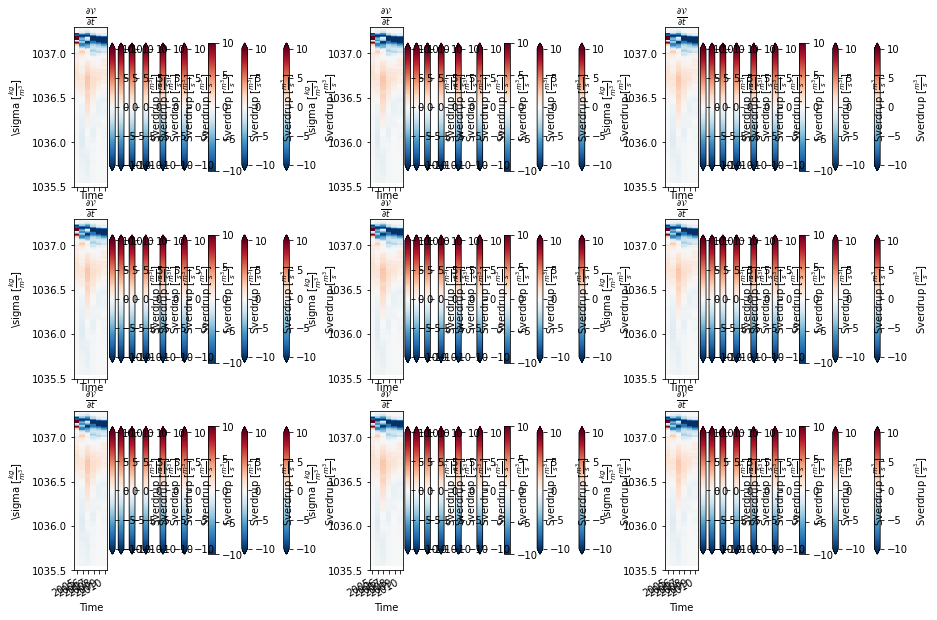

In [77]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for term in plot_terms:
    for i in range(0,3):
        for j in range(0,3):
            (term/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[i,j], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
            axes[i,j].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
            axes[i,j].set_xlabel('Time')
            axes[i,j].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
            axes[i,j].set_ylim(1035.5, 1037.3)

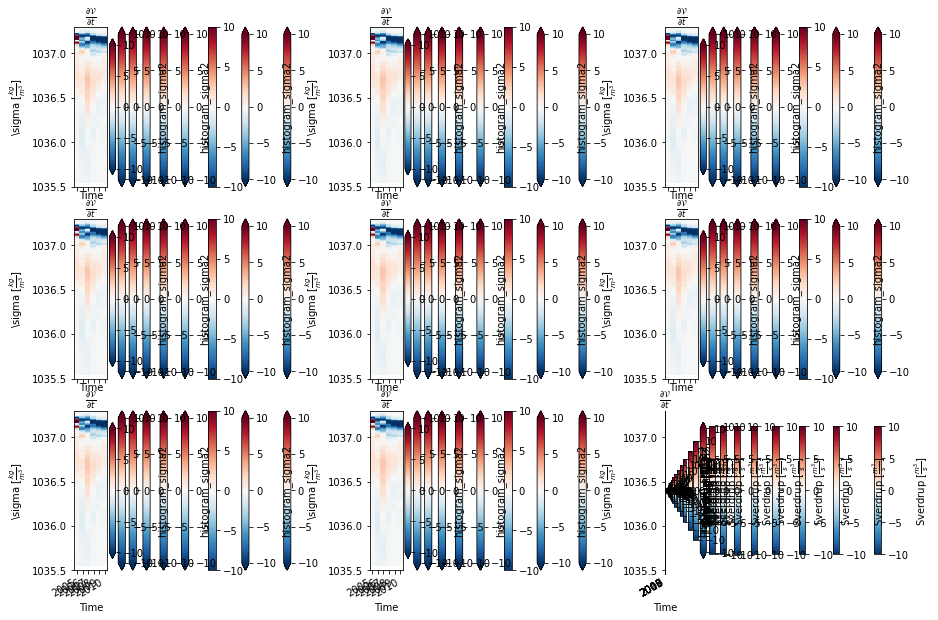

In [76]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for term in plot_terms:
    for i in range(0,3):
        for j in range(0,3):
            mapp = (term/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[i,j], vmax=10)
            fig.colorbar(mapp, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]')
            axes[i,j].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
            axes[i,j].set_xlabel('Time')
            axes[i,j].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
            axes[i,j].set_ylim(1035.5, 1037.3)

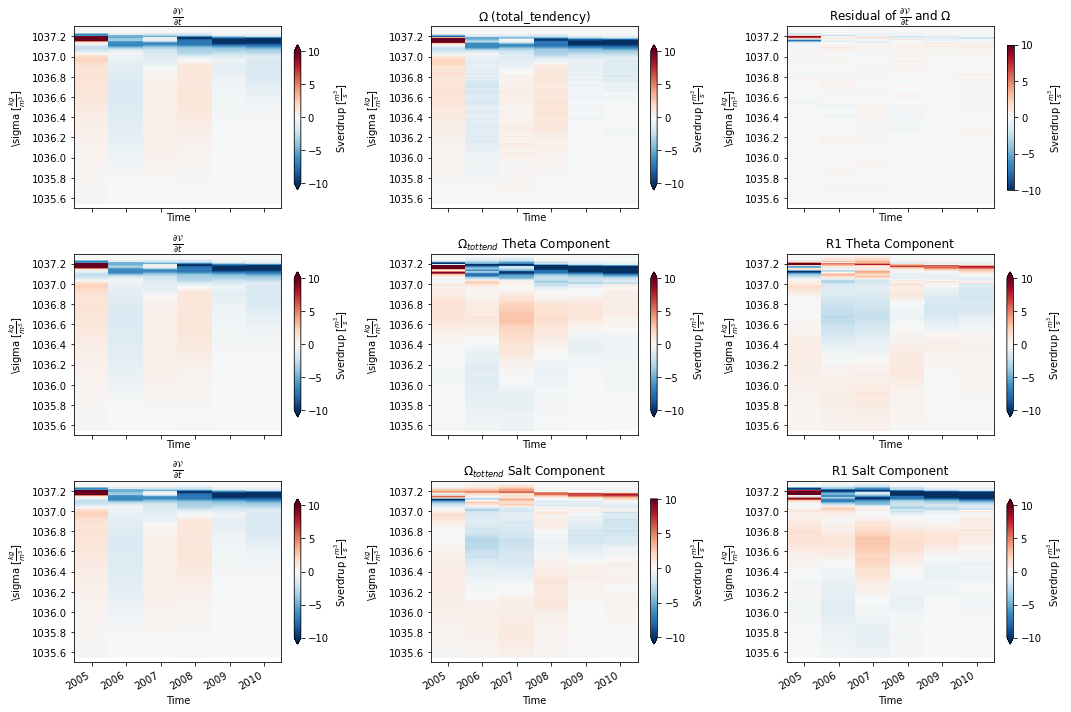

In [59]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
axes[0,0].set_xlabel('Time')#, fontsize=14)
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
axes[0,0].set_ylim(1035.5, 1037.3)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')#, fontsize=14)
axes[0,1].set_title('$\Omega$ (total_tendency)')
axes[0,1].set_ylim(1035.5, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
axes[0,2].set_ylim(1035.5, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
axes[1,0].set_ylim(1035.5, 1037.3)

(omega_total_th[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title(r'$\Omega_{tottend}$ Theta Component')
axes[1,1].set_ylim(1035.5, 1037.3)

(R1_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')#, fontsize=14)
axes[1,2].set_title(r'R1 Theta Component')
axes[1,2].set_ylim(1035.5, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
axes[2,0].set_ylim(1035.5, 1037.3)

(omega_total_slt[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title(r'$\Omega_{tottend}$ Salt Component')
axes[2,1].set_ylim(1035.5, 1037.3)

(R1_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R1 Salt Component')
axes[2,2].set_ylim(1035.5, 1037.3)

plt.tight_layout();

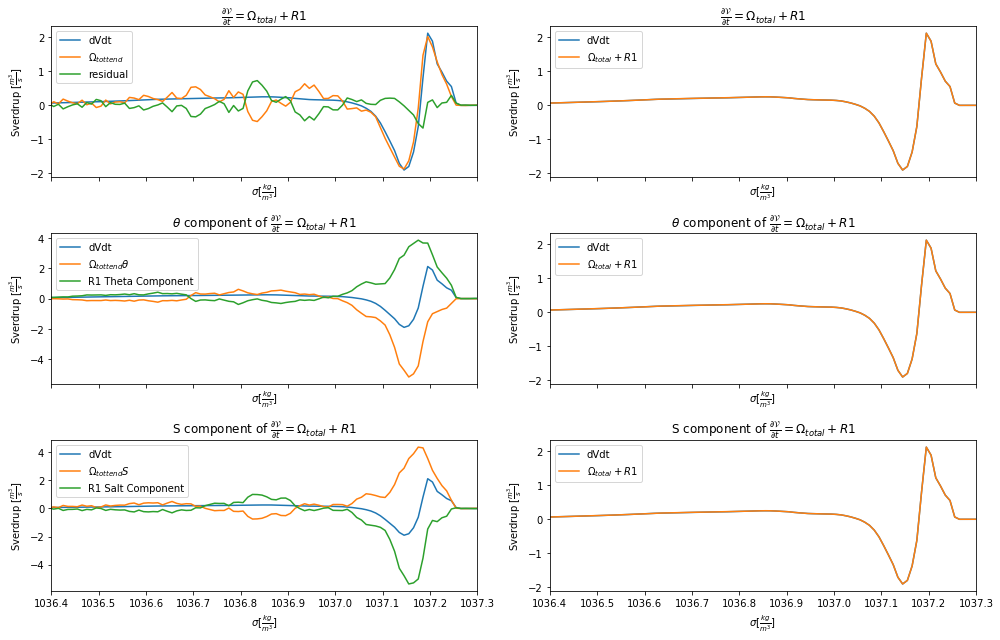

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
axes[1,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[1,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,1].set_xlim(1036.4, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}